<a href="https://colab.research.google.com/github/tawfiqam/MI564/blob/main/Word2Vec_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Word2Vec Embeddings

Word2vec is a tool that creates word embeddings: given an input text, it will create a vector representation of each word. Word2vec was originally implemented at Google by Tomáš Mikolov; et. al. but nowadays you can find lots of other implementations.

To create word embeddings, word2vec uses a neural network with a single hidden layer. The size of the hidden layer is referred to as the size in gensim.

The input is each word, along with a configurable context (typically 5 to 10 words). The context is referred to as the window in gensim.

What we will do is train this neural network to predict the word from its context. This is called a continuous bag of words

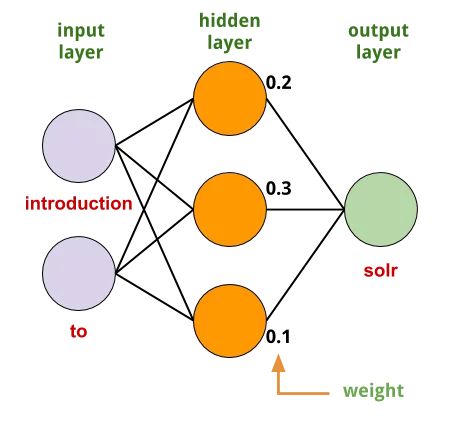

With CBOW you predict the word from the context, like in the figure above. We don’t care about the predictions here. Instead, when training is done, word2vec takes the weights of the hidden layer neurons for each word. In the figure above, we have [0.2, 0.3, 0.1] for the word solr. These weights are the vectors we’re looking for: the generated word embeddings.

If all goes well, word embeddings capture the semantics of each word pretty well. That’s because we assume that the context typically defines the word, which is true for most use-cases. For example, “Intel CPU, 16GB of RAM” and “Intel processor, 16GB of RAM” will create similar embeddings for CPU and processor. That said, sometimes the surrounding words don’t provide enough information, or that information could be misleading. For example, “this tool rocks” and “this tool stinks” will make rocks similar to stinks.

Still, if embeddings do capture the semantics to a reasonable level, you could use them for:

1. dynamic synonym expansion: the synoyms need not be exact. It just means that the produced words are close in the context of the corpus
2. use distance between vectors to measure similarity. The ditance between two vectors could be a relevancy score. The closer words are to each other, the more relevant
3. classification (any of the classifiers we introduced in this class) or clustering (e.g., K-means). If vectors of two words are closer, they are more likely to belong to the same group. 


This example is based on a tutorial here: 
https://sematext.com/blog/word-embeddings-gensim-word2vec-tutorial/ 

I also based this document on this example about the Simpsons:
https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial?select=simpsons_dataset.csv

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20,'figure.figsize':(10,8)})

In [2]:
import pandas as pd
#we will need datetime in order to specify the timeline we need to collect the data
import datetime as dt
#regular expressions will help us clean the text
import re
#gensim
import gensim
#LDA model
from gensim.models import LdaModel
#Use this to setup a dictionay
from gensim.corpora import Dictionary
#This will allow us to get the coherence models
from gensim.models import CoherenceModel
#gensim is a python library used mostly for NLP analysis
#corpora allows us to build a corpus out of different 
#documents
from gensim import corpora
#Defaultdict is a container like dictionaries present in the module collections. 
#Defaultdict is a sub-class of the dict class that returns a dictionary-like object. 
#The functionality of both dictionaries and defualtdict are almost same except for 
#the fact that defualtdict never raises a KeyError. It provides a default value 
#for the key that does not exists.
from collections import defaultdict

#importing ntlk
#we will be using nltk to create bag of words.
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
#this recognizes where a sentence starts & ends
#http://www.nltk.org/_modules/nltk/tokenize/punkt.html
nltk.download('punkt')
#Wordnet is important for Lemmatization ==> seel later when we dig into this
#https://www.nltk.org/howto/wordnet.html
nltk.download('wordnet')
#use nltk to get stopwords
nltk.download('stopwords')
#create a stoplist that includes all the english stop words
stopwords_english = stopwords.words('english')
display('here is a subset of the stop words')
display(stopwords_english[0:10])
#now we import the wrapper in order to use the API
# Text Cleaning
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'here is a subset of the stop words'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item. For example, if we are looking through a document and want to do topic modeling, it is important that we do not see each inflection of the word differently. That would confuse the topic modeling algorithm. So, for example, we'd want to see the words "studies" "studied" and "studying" as "study." [1,2]




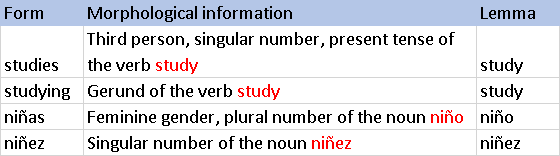

Another simpler way of doing this is called stemming. Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. This indiscriminate cutting can be successful in some occasions, but not always, and that is why we affirm that this approach presents some limitations.

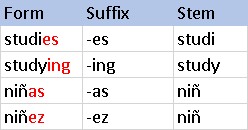

References:

[1] https://en.wikipedia.org/wiki/Lemmatisation

[2] [https://blog.bitext.com what-is-the-difference-between-stemming-and-lemmatization/]()

In [3]:
#We are using nltk lemmatizer 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

##Cleaning text and creating documents

We will use the simpsons as an example

Dataset can be found [here](https://colab.research.google.com/drive/1y-Ti0_4-xA7dFUtOITUgXAply7jTnDdY?usp=sharing). 

In [4]:
#creating smaller dataframe
#we do not need all the columns
df = pd.read_csv('simpsons_dataset.csv')

In [5]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [6]:
def clean_pass(text): 
    #make string lowercase 
    text = str(text)
    text = text.lower()

    #tokenize
    #create bag of words
    #1-grams 
    tokens = nltk.word_tokenize(text) 
    clean_text = []
    
    #remove stopwords, puncuation, then lemmatize
    for word in tokens:
        if (word not in stopwords_english and word not in string.punctuation): 
            token = wordnet_lemmatizer.lemmatize(word)
            clean_text.append(token)
            
    #remove words of length 3 or smaller        
    clean_text = [token for token in clean_text if len(token) > 2] 
            
    return clean_text      

In [7]:
df['clean_text'] = df.spoken_words.apply(clean_pass)

In [8]:
df.clean_text

0         [actually, little, sometimes, disease, magazin...
1                                          [mr., bergstrom]
2         [n't, know, although, sure, like, talk, n't, t...
3                                     [life, worth, living]
4         [poll, open, end, recess, case, decided, put, ...
                                ...                        
158309                                               [back]
158310             [see, class, lyme, disease, turned, ...]
158311                                  [psy-cho-so-ma-tic]
158312                                        [mean, crazy]
158313                                       [mean, faking]
Name: clean_text, Length: 158314, dtype: object

In [9]:
'''
Parameters:
**********
**********

min_count: tells word2vec to ignore rare words. These are words with lower frequency compared to the specified value.

size: This is the size of the hidden layer which, in turn, determines the size of the word 
embedding vector. Defaults to 100. You might think that more neurons might capture more nuances, 
but beyond a certain point (higher with the amount of training data) there might be too much noise 
coming down from their initial state. And of course training time and resources will grow as size grows.

window: gives the width of the context: how many surrounding words to consider.

workers:Use these many worker threads to train the model (=faster training with multicore machines). The more cores you 
are using, the faster the model will be trained. 
'''

from gensim.models import Word2Vec
model = Word2Vec(df.clean_text.values, min_count=5,size=300,workers=6, window=5)

##Use weight to find most similar words

In [10]:
model.most_similar('homer')

[('marge', 0.9025774598121643),
 ('bart', 0.8861255049705505),
 ('abe', 0.8835315704345703),
 ('lisa', 0.8748146295547485),
 ('grampa', 0.8260552287101746),
 ('abraham', 0.8171519041061401),
 ('monty', 0.8138493299484253),
 ('gene', 0.8080716133117676),
 ('dry-cleaning', 0.8047050833702087),
 ('ned', 0.7982621192932129)]

In [11]:
model.most_similar('beer')

[('drink', 0.9244052171707153),
 ('gim', 0.9179284572601318),
 ('ride', 0.9024304747581482),
 ('hand', 0.9003415107727051),
 ('car', 0.8951773643493652),
 ('foot', 0.8814351558685303),
 ('responsibly', 0.8807529211044312),
 ('head', 0.8802851438522339),
 ('lunch', 0.8765338659286499),
 ('grab', 0.8622791767120361)]

In [12]:
model.most_similar('marge')

[('homer', 0.9025774598121643),
 ('grampa', 0.8857992887496948),
 ('bart', 0.8713898062705994),
 ('honey', 0.8666011691093445),
 ('abe', 0.8571873903274536),
 ('sweetie', 0.855586588382721),
 ('homie', 0.8541864156723022),
 ('milhouse', 0.8512735962867737),
 ('son', 0.8457044363021851),
 ('lisa', 0.8362926840782166)]

In [13]:
model.most_similar('bart')

[('lisa', 0.9710537195205688),
 ('homer', 0.8861255049705505),
 ('marge', 0.8713898062705994),
 ('abe', 0.851828932762146),
 ('grampa', 0.8468103408813477),
 ('milhouse', 0.8190326690673828),
 ('honey', 0.8156579732894897),
 ('sweetie', 0.8055803775787354),
 ('maggie', 0.7965997457504272),
 ('late', 0.7938587069511414)]

##Find how similar two tokens?

In [14]:
model.similarity("maggie", "baby")

0.8126699

##Which does not fit?

In [15]:
model.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [16]:
model.doesnt_match(['jimbo', 'milhouse', 'kearney'])

'milhouse'

##Analogy

In [17]:
model.most_similar(positive=["man", "homer"], negative=["marge"], topn=10)

[('lady', 0.7262610197067261),
 ('evening', 0.6614482402801514),
 ('real', 0.6582654714584351),
 ('people', 0.6543217897415161),
 ('name', 0.6507886648178101),
 ('sportsmanship', 0.6482361555099487),
 ('movie', 0.6414693593978882),
 ('bony', 0.6394360661506653),
 ('young', 0.638756513595581),
 ('fashioned', 0.6337717771530151)]

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.manifold import TSNE

In [19]:
#Get all the words in the word2vec model
all_vocab = list(model.wv.vocab.keys())
#create a dictionary with the word as key and the weight in word2vec as value
#the weight based on the word2vec model
#to do so, we use model[word]
data_dict = {word: model[word] for word in all_vocab}
#we will need to swap columns for rows
result = pd.DataFrame(data=data_dict).transpose()

In [20]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
actually,0.148013,0.091924,0.169276,-0.018801,-0.020512,-0.015504,0.210419,-0.067090,0.006920,-0.056017,-0.064140,-0.032985,-0.089962,0.021960,-0.019776,0.046807,-0.083524,0.199511,-0.237129,-0.076024,0.007461,-0.031445,-0.228347,-0.065545,-0.004214,-0.162451,0.162539,0.310113,-0.129868,0.312408,0.258260,-0.008248,-0.133402,0.137087,0.268561,0.035865,-0.013001,0.287403,0.180045,0.229387,...,-0.120219,-0.135500,0.106240,0.164188,0.125971,-0.067621,-0.247649,0.085169,0.123503,0.100494,-0.042926,-0.088258,0.074719,-0.061600,0.262374,-0.014720,-0.085697,-0.012441,0.124930,-0.066430,0.337884,0.010276,0.275504,-0.378239,-0.036111,0.165035,0.132864,-0.191895,-0.011396,-0.036676,-0.198995,0.087280,-0.077126,-0.188019,-0.230929,0.053226,-0.099762,0.055870,0.010044,0.005095
little,0.020817,0.300496,0.013549,-0.006959,-0.119558,0.061103,0.039197,0.104456,0.237668,-0.335255,0.376449,0.247767,0.263622,0.010508,-0.308187,-0.073973,0.430286,0.251939,-0.409664,0.294786,0.106500,-0.173504,-0.120272,0.422268,-0.262388,-0.437060,0.218518,0.307426,-0.177348,0.170701,0.452894,0.325215,-0.204289,0.063018,0.421692,-0.175389,0.398244,-0.102107,-0.006039,-0.036963,...,-0.250731,-0.136856,-0.000879,0.248319,0.236332,-0.256358,-0.140140,-0.021765,-0.293321,-0.054420,0.014084,0.360201,0.044907,-0.128332,0.270287,-0.036290,-0.132666,-0.341864,0.527924,0.253077,0.470972,0.017684,0.639160,-0.109762,-0.266732,0.100441,-0.223431,-0.411819,-0.187949,-0.096165,-0.043236,-0.402693,0.320624,0.045371,0.181927,0.022372,-0.173174,-0.698600,-0.125483,0.268117
sometimes,0.218232,0.223599,0.115642,-0.153161,-0.068286,0.061906,0.245494,-0.042691,-0.001848,-0.036420,0.079537,0.000705,-0.067633,-0.063512,-0.066462,0.057934,0.050385,0.156864,-0.126838,-0.148975,0.088261,-0.132861,-0.166851,0.047210,-0.042789,-0.211385,0.145163,0.346805,-0.068792,0.239996,0.241900,0.117489,-0.122721,0.166718,0.338236,-0.010517,0.040613,0.183950,0.121872,0.211289,...,-0.133195,-0.120840,0.088609,0.160515,0.195297,-0.251946,-0.319272,0.102335,0.057014,0.001361,0.046872,-0.002822,0.044404,-0.162697,0.317080,-0.040760,-0.179988,-0.065009,0.219787,-0.024595,0.266463,0.061015,0.188595,-0.331139,0.012045,0.183057,0.010851,-0.066150,0.020073,0.038769,-0.160238,0.109519,-0.034573,-0.175603,-0.178264,-0.040678,-0.128115,-0.092829,0.026643,0.092804
disease,0.083574,0.150456,0.179504,0.016496,0.030200,-0.015241,0.065293,-0.054724,0.062365,-0.052480,-0.107274,0.123956,0.015251,-0.018559,-0.076330,-0.050266,-0.088210,0.105100,-0.262293,-0.011546,0.071761,-0.025004,-0.148252,-0.093728,-0.065034,-0.151738,0.287637,0.228840,-0.043369,0.044158,0.138791,-0.018745,-0.104491,0.107536,0.234146,0.002138,-0.021392,0.067038,0.035966,0.165381,...,-0.073456,-0.030179,0.073716,0.102187,0.116418,-0.164489,-0.078679,-0.003498,0.010337,0.016084,0.077358,-0.072965,-0.055950,-0.047976,0.133045,-0.068455,-0.033527,-0.150602,0.130217,0.029031,0.098780,-0.137888,0.145936,-0.198722,0.089442,0.005440,0.008739,-0.039087,0.084272,-0.013991,-0.129074,-0.036879,-0.012316,-0.119488,-0.137036,-0.031299,-0.108736,0.056343,0.064430,0.097684
magazine,0.118059,0.120377,0.219407,0.027282,0.023580,-0.040121,0.098723,-0.038910,0.096892,-0.090976,-0.169717,0.172666,-0.009341,0.063935,-0.029030,-0.016296,-0.169329,0.121205,-0.352710,0.072070,0.130219,0.029220,-0.105534,-0.162693,-0.051311,-0.228862,0.406942,0.265283,-0.176317,0.071696,0.192771,-0.050211,-0.152684,0.120084,0.303393,0.098437,0.024527,0.129637,0.083691,0.224368,...,-0.139849,-0.142232,0.151396,0.034986,0.143027,-0.094030,-0.130838,-0.058636,0.049169,-0.018380,0.047470,-0.215878,-0.016713,0.041061,0.138531,-0.063176,0.041019,-0.110613,0.130479,0.005158,0.175953,-0.201113,0.204795,-0.248177,0.150066,0.050235,0.

In [21]:
vocab = list(model.wv.vocab)
X = model[vocab]

In [22]:
X

array([[ 0.14801306,  0.09192396,  0.16927639, ...,  0.05586996,
         0.01004438,  0.00509487],
       [ 0.02081692,  0.3004963 ,  0.01354929, ..., -0.6986003 ,
        -0.12548295,  0.2681168 ],
       [ 0.21823227,  0.2235991 ,  0.11564195, ..., -0.09282877,
         0.02664263,  0.09280416],
       ...,
       [ 0.01292027,  0.01765006,  0.00919096, ..., -0.00089809,
         0.00761361,  0.01184941],
       [ 0.01773413,  0.04594963,  0.0262607 , ...,  0.0149403 ,
         0.02007267,  0.00990881],
       [ 0.00815432,  0.0267988 ,  0.02924095, ...,  0.01358036,
         0.00932312,  0.01095144]], dtype=float32)

##PCA v. t-SNE

Remember when we [introduced PCA](https://github.com/tawfiqam/MI564/blob/main/PCA__Introduction.ipynb) ealier in this class. Principle component analysis is a data reduction and analysis technique that is especially important in "large, mutidimensional datasets." Reducing the dimensionality of the data to principle component analysis can help us better understand the patterns in the data by removing the "noise" from variables that do not contribue much to the understanding of the data structure.

The problem though is that there are too many dimensions in word embeddings (in our case 300 because we set the size to 300). That is why we are going to be using t-SNE instead of PCA.

One of the most major differences between PCA and t-SNE (T- distributed Stochastic Neighbor Embedding) is that t-SNE preserves only local similarities whereas PA preserves large scale variance across the dataset. t-SNE takes a set of points in high dimensional data (as it is in our case) and converts it into low dimensional data.

source:https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d

In [23]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [24]:
X_tnse_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [25]:
X_tnse_df.head()

,x,y
actually,48.706066,-21.335005
little,31.209198,-15.684355
sometimes,45.334534,-18.781378
disease,17.542818,-50.569260
magazine,47.311451,-56.458244


In [26]:
def display_closestwords_tsnescatterplot(model, word):
    
    #create an array with the size of the model (300)
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word,topn=20)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coordinates for 2 dimensions
    tsne = TSNE(n_components=2)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


##Visualizing similarity

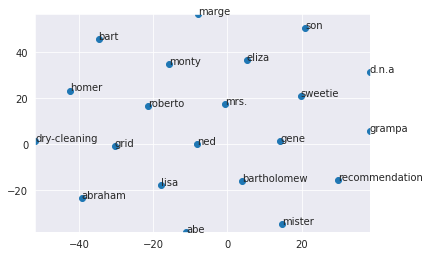

In [27]:
display_closestwords_tsnescatterplot(model, 'homer')

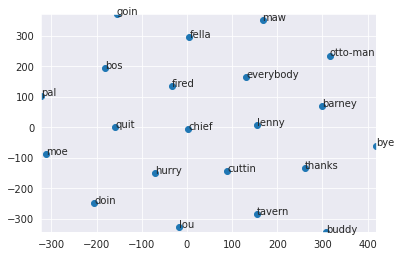

In [28]:
display_closestwords_tsnescatterplot(model, 'moe')

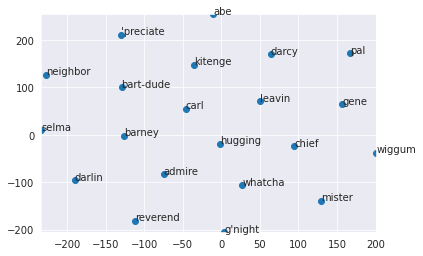

In [29]:
display_closestwords_tsnescatterplot(model, 'chief')

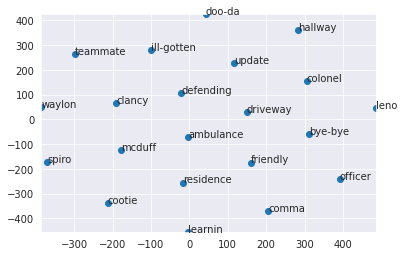

In [30]:
display_closestwords_tsnescatterplot(model, 'officer')

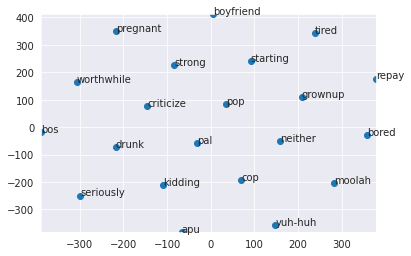

In [31]:
display_closestwords_tsnescatterplot(model, 'apu')

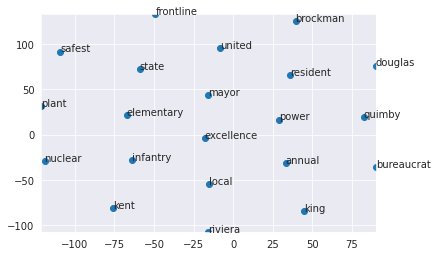

In [32]:
display_closestwords_tsnescatterplot(model, 'nuclear')

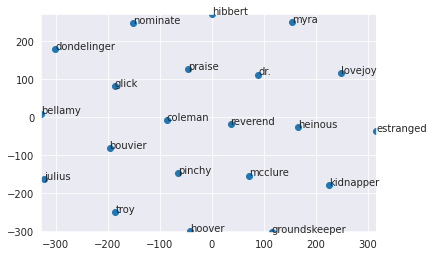

In [33]:
display_closestwords_tsnescatterplot(model, 'hibbert')

##Visualizing embeddings

In [34]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    #initialize using PCA
    #take 2500 iterations over the data
    #n_components = 2 --> reduce dimensionality to 2
    #perplexity -- the higher the perplexity, the clearer the drawing, but computationally constly
    #read more here: https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0, flags=flags)


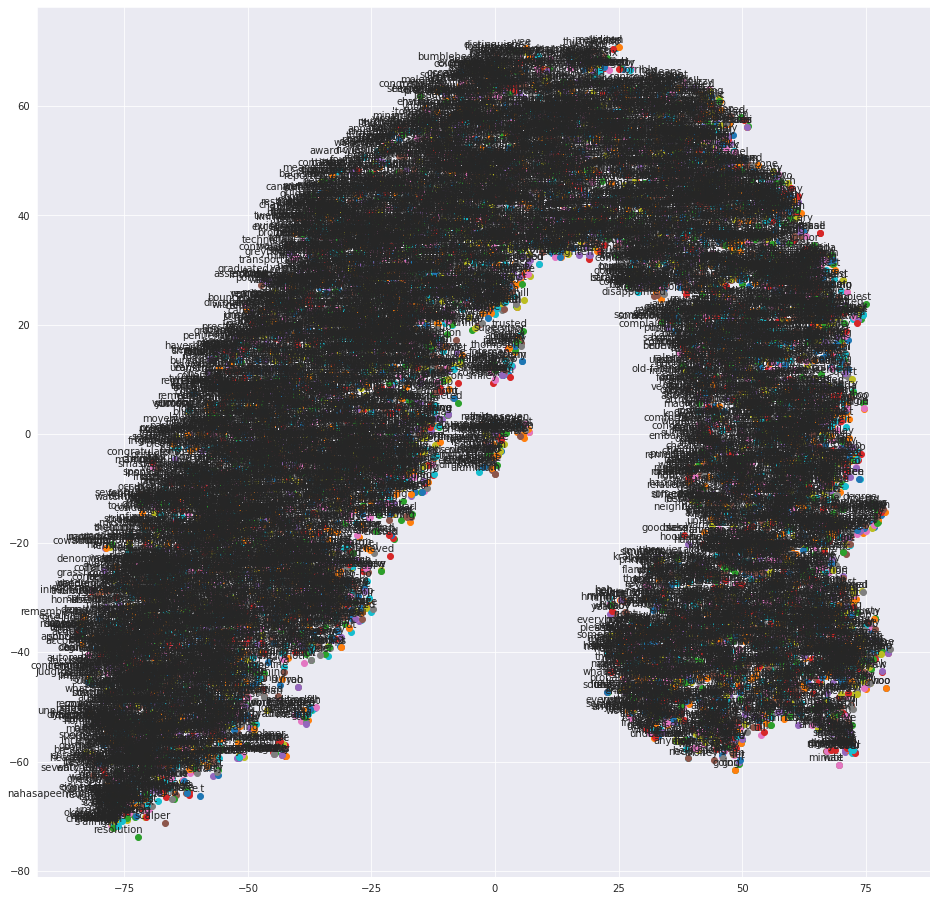

In [35]:
tsne_plot(model)

What if we were more selective by increasing the minimum count of words in the corpus? 

Notice that I'm changing min_count here...

In [36]:
model = Word2Vec(df.clean_text.values, min_count=250,size=300,workers=6, window=5)

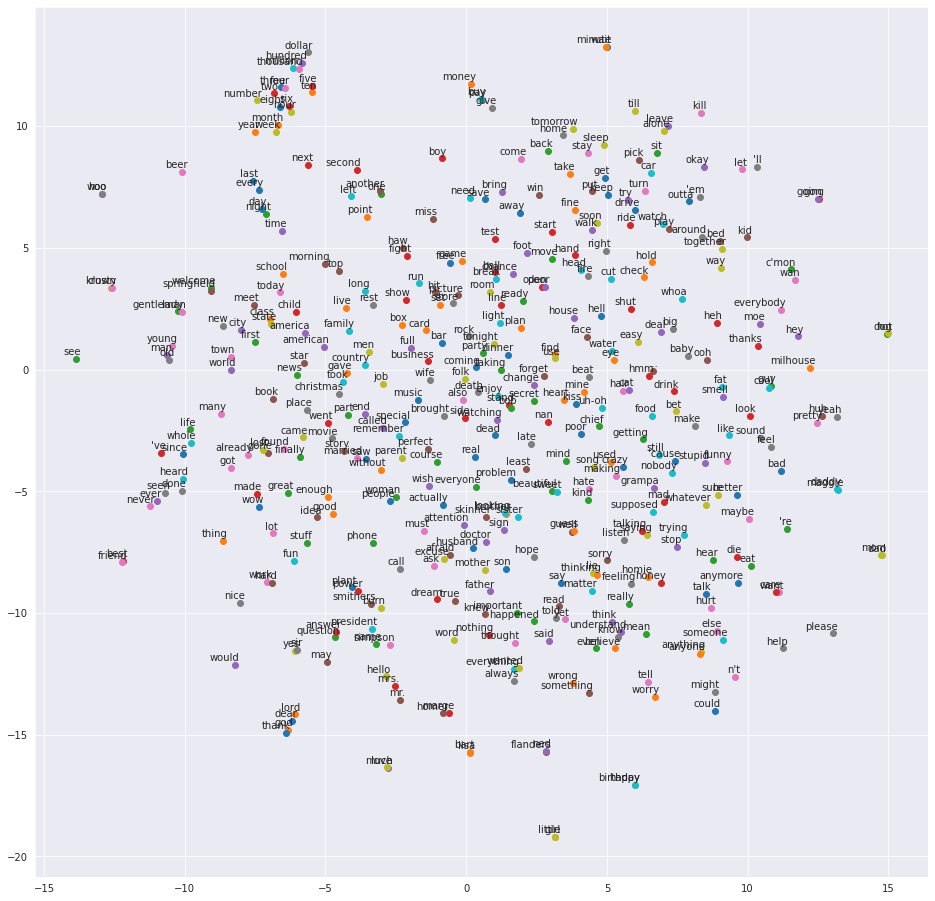

In [37]:
tsne_plot(model)

In [38]:
model = Word2Vec(df.clean_text.values, min_count=300,size=300,workers=6, window=5)

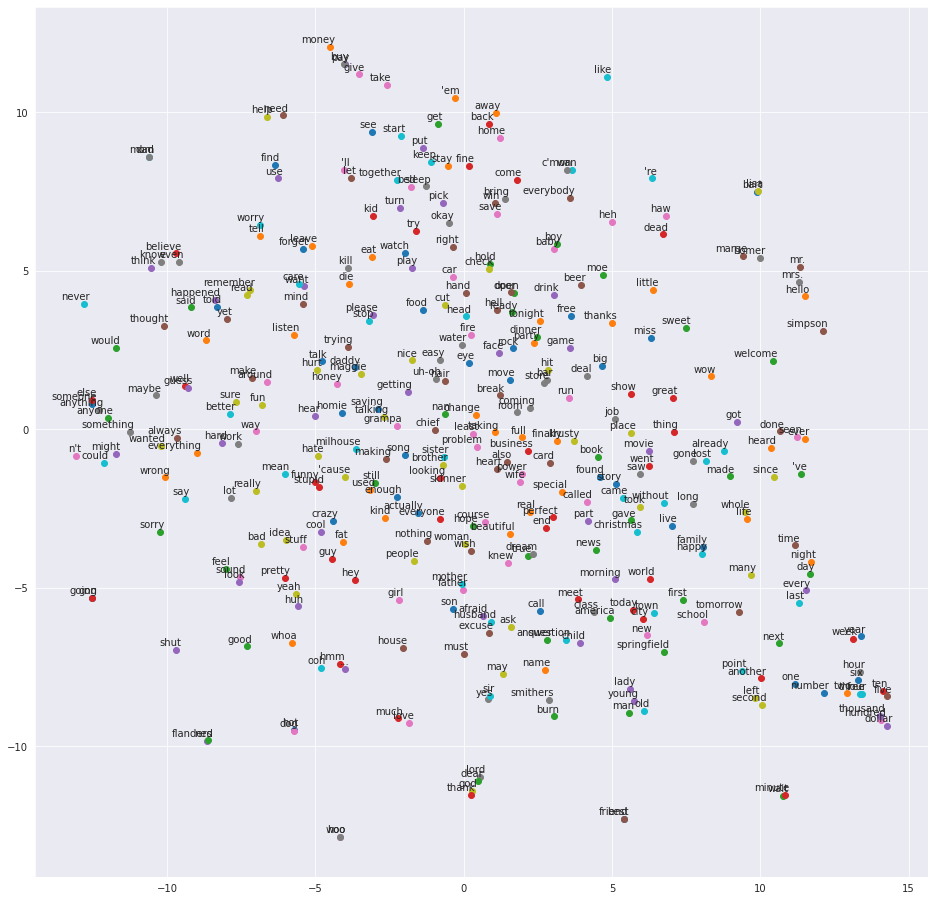

In [39]:
tsne_plot(model)

In [40]:
model = Word2Vec(df.clean_text.values, min_count=1000,size=300,workers=6, window=5)

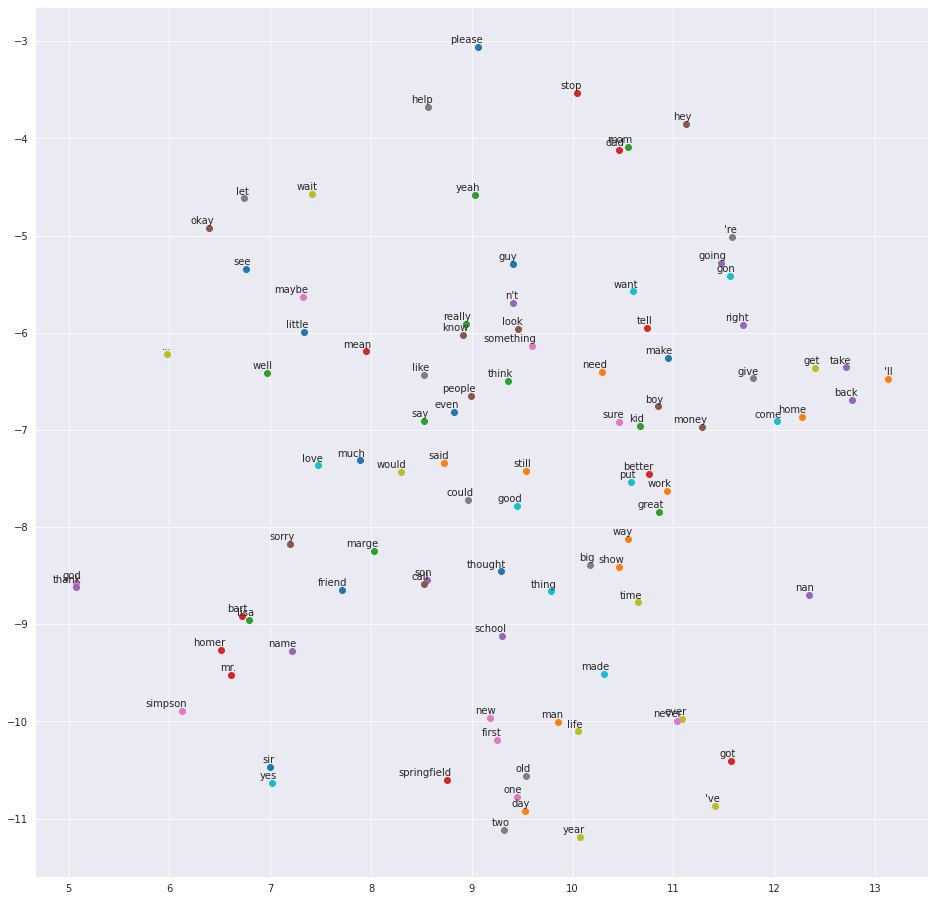

In [41]:
tsne_plot(model)